## Deep Neural Network with PyTorch

Credits: \
https://jovian.ai/aakashns/04-feedforward-nn \
https://pytorch.org/docs/stable/data.html

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [3]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size=128

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


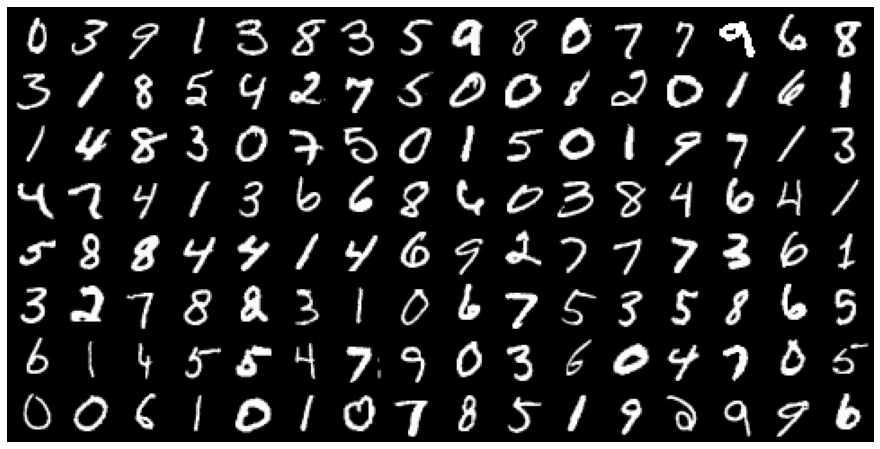

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

### Model
We'll create a neural network with one hidden layer.

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, \
                                result['val_loss'], result['val_acc']))

In [9]:
input_size = 784
hidden_size = 32
num_classes = 10

In [10]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [11]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3151307106018066
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1363,  0.1570,  0.1273, -0.1090,  0.0925, -0.1675, -0.2022, -0.0798,
         -0.0010, -0.0841],
        [-0.2065,  0.1579,  0.0471, -0.1057,  0.1951, -0.1952, -0.2298, -0.1883,
          0.0253, -0.2307]])


### Using a GPU
Check if a GPU is available and the required NVIDIA CUDA drivers are installed:

In [13]:
torch.cuda.is_available()

False

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cpu')

Define a function that can move data and model to a chosen device:

In [16]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


Define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data, and an `__len__` method to get the number of batches.

In [18]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors that have been moved to the GPU's RAM have a `device` property which includes the word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [20]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([1, 1, 8, 4, 8, 4, 1, 3, 2, 5, 7, 7, 9, 4, 6, 6, 3, 2, 3, 6, 8, 8, 9, 6,
        0, 1, 9, 1, 0, 9, 3, 0, 3, 4, 2, 2, 4, 4, 6, 2, 4, 9, 4, 4, 3, 5, 9, 0,
        1, 2, 9, 0, 5, 0, 3, 0, 8, 1, 2, 0, 2, 7, 8, 7, 7, 8, 8, 0, 5, 4, 1, 3,
        0, 3, 1, 7, 3, 4, 9, 6, 5, 1, 4, 1, 1, 2, 6, 9, 0, 6, 7, 5, 7, 1, 6, 2,
        9, 1, 8, 3, 8, 4, 4, 4, 5, 9, 8, 9, 6, 0, 5, 5, 1, 1, 7, 9, 3, 6, 4, 9,
        1, 1, 3, 2, 1, 0, 2, 3, 8, 7, 1, 1, 6, 1, 9, 1, 3, 6, 9, 1, 9, 4, 6, 2,
        2, 8, 6, 8, 8, 0, 3, 1, 5, 4, 7, 6, 8, 9, 7, 1, 0, 2, 2, 0, 7, 9, 6, 1,
        7, 1, 6, 1, 3, 8, 0, 1, 0, 5, 7, 9, 7, 3, 7, 4, 8, 3, 8, 1, 8, 1, 5, 4,
        9, 5, 4, 7, 0, 8, 3, 8, 1, 2, 1, 8, 5, 1, 0, 0, 5, 8, 6, 8, 1, 8, 9, 6,
        0, 2, 8, 6, 9, 3, 5, 6, 9, 9, 9, 6, 3, 2, 1, 0, 9, 6, 8, 6, 8, 4, 3, 8,
        7, 8, 6, 5, 7, 2, 6, 1, 9, 0, 6, 1, 9, 4, 3, 3])


### Training the model

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device.

In [22]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3240580558776855, 'val_acc': 0.07265625149011612}]

In [24]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2468, val_acc: 0.9285
Epoch [1], val_loss: 0.2042, val_acc: 0.9394
Epoch [2], val_loss: 0.1856, val_acc: 0.9449
Epoch [3], val_loss: 0.1805, val_acc: 0.9485
Epoch [4], val_loss: 0.1809, val_acc: 0.9436


In [25]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1391, val_acc: 0.9605
Epoch [1], val_loss: 0.1351, val_acc: 0.9615
Epoch [2], val_loss: 0.1376, val_acc: 0.9597
Epoch [3], val_loss: 0.1378, val_acc: 0.9599
Epoch [4], val_loss: 0.1339, val_acc: 0.9624


Text(0.5, 1.0, 'Loss vs. No. of epochs')

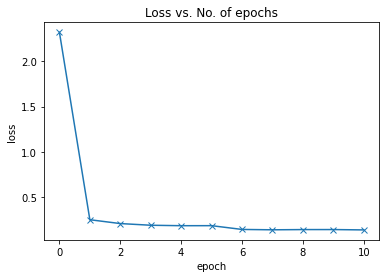

In [26]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

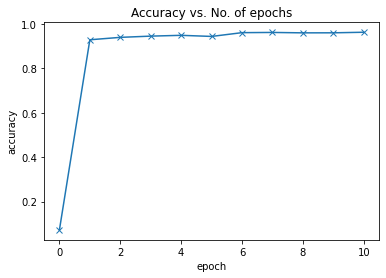

In [27]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')